In [1]:
import numpy as np
from pynq import allocate
from pynq import Overlay
from PIL import Image
import numpy as np
from matplotlib import cm
import math

In [2]:
ol = Overlay("mandelbrot14b5v.bit")
#ol?
dma = ol.axi_dma

In [3]:
imgwidth = 800
imgheight = 800

maxiterations = 100

StartX = -2.0
StopX = 0.47
StartY = -1.12
StopY = 1.12

inputregs = ol.axi_stream_template_0

inputregs.write(0x1C,imgwidth-1) #Output width
inputregs.write(0x20,imgheight-1) #Output height

inputregs.write(0x18,maxiterations) #Max iterations

inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y

inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X

def start_image():
    inputregs.write(0x10,0x1)
    inputregs.write(0x10,0x0)

In [4]:
input_buffer = allocate(shape=(imgheight,imgwidth), dtype=np.uint32)

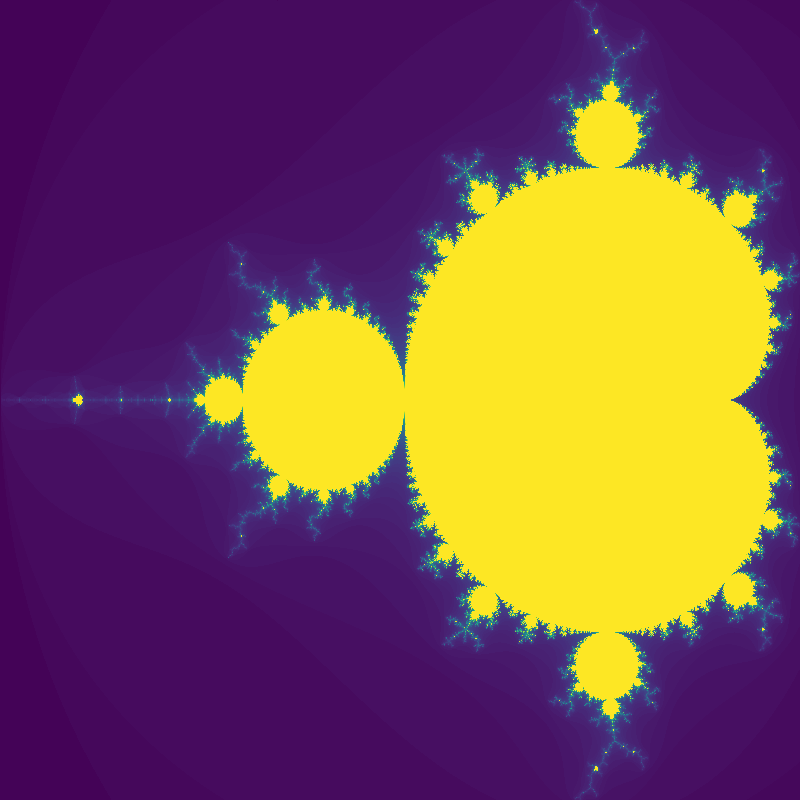

Render time: 0.421 seconds
-2.0 0.47 -1.12 1.12


In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import time

colormap_dropdown = widgets.Dropdown(
    options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'turbo'],
    value='viridis',
    description='Colormap:'
)
save_button = widgets.Button(description="Save Image")
colormap_box = widgets.HBox([colormap_dropdown, save_button])

DispButton = widgets.Button(description="Display")
LeftButton = widgets.Button(description="Left")
RightButton = widgets.Button(description="Right")
UpButton = widgets.Button(description="Up")
DownButton = widgets.Button(description="Down")
ResetButton = widgets.Button(description="Reset")
ZoomButton = widgets.Button(description="Zoom in")
DebugButton = widgets.Button(description="Debug")
nav_box = widgets.HBox([DispButton, LeftButton, RightButton, UpButton, DownButton, ResetButton, ZoomButton, DebugButton])

image = None

def update_image(change=None):
    global image
    clear_output(wait=True)
    inputregs.write(0x14, imgwidth)
    
    
    t0 = time.time()
    
    start_image()
    for i in range(imgheight):
        dma.recvchannel.transfer(input_buffer[i])
        dma.recvchannel.wait()
    

    t1 = time.time()
    elapsed = t1 - t0
    
    data = np.frombuffer(input_buffer, dtype=np.uint32).reshape((imgwidth, imgheight))
    norm_data = data / data.max()
    cmap = cm.get_cmap(colormap_dropdown.value)
    colored_data = (cmap(norm_data)[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(colored_data)
    display(nav_box, colormap_box, image)
    
    print(f"Render time: {elapsed:.3f} seconds")
    print(StartX, StopX, StartY, StopY)

def save_image(_):
    if image:
        image.save("mandelbrot.png")

def update_coords(dx=0, dy=0, zoom=False, reset=False):
    global StartX, StopX, StartY, StopY
    width = StopX - StartX
    height = StopY - StartY
    if reset:
        StartX, StopX = -2.0, 0.47
        StartY, StopY = -1.12, 1.12
    elif zoom:
        posX, posY = (StopX + StartX)/2, (StopY + StartY)/2
        ratio = imgwidth/imgheight
        StartX, StopX = posX - width*0.2*ratio, posX + width*0.2*ratio
        StartY, StopY = posY - height*0.2, posY + height*0.2
    else:
        StartX += dx*width
        StopX += dx*width
        StartY += dy*height
        StopY += dy*height
    inputregs.write(0x0C,int(round(StartX*(2**28))))
    inputregs.write(0x04,int(round(StopX*(2**28))))
    inputregs.write(0x08,int(round(StartY*(2**28))))
    inputregs.write(0x00,int(round(StopY*(2**28))))
    update_image()

DispButton.on_click(lambda _: update_image())
LeftButton.on_click(lambda _: update_coords(dx=-0.25))
RightButton.on_click(lambda _: update_coords(dx=0.25))
UpButton.on_click(lambda _: update_coords(dy=-0.1))
DownButton.on_click(lambda _: update_coords(dy=0.1))
ResetButton.on_click(lambda _: update_coords(reset=True))
ZoomButton.on_click(lambda _: update_coords(zoom=True))
DebugButton.on_click(lambda _: print(StartX, StopX, StartY, StopY))
colormap_dropdown.observe(update_image, names='value')
save_button.on_click(save_image)

update_image()